## Run default configurations - "non-flat"
Print out Psats, NET, NET_wafer


In [28]:
# See what yaml files are locally available.
!pwd

/Users/ruhl/code/bolo_calc_runs/pbdr_v2_nonflat


In [29]:
# Standard imports
import numpy as np
import yaml
import toml
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline  
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8,8]

# bolo-calc import
from bolo import Top

## Run
Read yaml files, run bolo_calc, store some outputs into dictionary called "data".
Print some outputs to table.

In [30]:
data = {}

yamlfiles = ['SPLAT_20210630.yaml']

#read fixed PSATs from .toml file
psat_dict = toml.load("FixedPsats.toml")

for yamlfile in yamlfiles:
    print(yamlfile)
    data[yamlfile] = {}
    dd = yaml.safe_load(open(yamlfile))
    version_date = str(dd['version']['date'])
    version_telescope = str(dd['version']['name'])
    print('{0:8s}  Popt(pW) Psat(pW)   NET    NET_wafer'.format(version_telescope))
    del dd['version']

    # location of atmosphere file
    dd['sim_config']['config_dir'] = 'config'
    
    ch_names = list(dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'].keys())
    
    #---------
    #convert to Watts
    for channel in ch_names:
        psat_dict[yamlfile.partition('.')[0]][channel] *= 1e-12

    #set psat factor to None & delete psat entry from channel default
    dd['instrument']['channel_default']['psat_factor'] = None
    del dd['instrument']['channel_default']['psat']

    #assign SI psat values at the channel level
    for channel in ch_names:
        dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][channel]['psat'] = psat_dict[yamlfile.partition('.')[0]][channel]
    #---------
    
    # Save some of the defaults things
    data[yamlfile]['defaults']={}
    data[yamlfile]['defaults']['Yield']=dd['instrument']['channel_default']['Yield']
    data[yamlfile]['defaults']['Tc']=dd['instrument']['channel_default']['Tc']
    data[yamlfile]['defaults']['waist_factor']=dd['instrument']['channel_default']['waist_factor']
    data[yamlfile]['defaults']['read_frac']=dd['instrument']['channel_default']['read_frac']
    data[yamlfile]['defaults']['site']=dd['instrument']['site']
    data[yamlfile]['defaults']['elevation']=dd['instrument']['elevation']
    data[yamlfile]['defaults']['pwv']=dd['instrument']['pwv']

    top = Top(**dd)
    top.run()
    
    for chan in top.instrument.tables.keys():
        if chan.split('_')[0] == 'cam' :
            chname = chan.split('_')[2] + '_' + chan.split('_')[3]
            data[yamlfile][chname] = {}
            #
            # Grab things we're going to print and give them short names and store them in the dictionary.
            popt = top.instrument.tables[chan]['opt_power'][0]
            data[yamlfile][chname]['popt'] = popt
            psat = top.instrument.tables[chan]['P_sat'][0]
            data[yamlfile][chname]['psat'] = psat
            net = top.instrument.tables[chan]['NET'][0]
            data[yamlfile][chname]['net'] = net
            netwafer = top.instrument.tables[chan]['NET_arr'][0]
            data[yamlfile][chname]['netwafer'] = netwafer
            #
            # Grab things we're not going to print and store them in the dictionary.
            data[yamlfile][chname]['effic'] = top.instrument.tables[chan]['effic'][0]
            data[yamlfile][chname]['nep_photon'] = top.instrument.tables[chan]['NEP_ph'][0]
            data[yamlfile][chname]['nep_phonon'] = top.instrument.tables[chan]['NEP_bolo'][0]
            data[yamlfile][chname]['nep_readout'] = top.instrument.tables[chan]['NEP_read'][0]
            data[yamlfile][chname]['Gdyn'] = top.instrument.tables[chan]['G'][0]
            data[yamlfile][chname]['corr_fact'] = top.instrument.tables[chan]['corr_fact'][0]
            data[yamlfile][chname]['bandcenter'] = dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][chname]['band_center']
            data[yamlfile][chname]['fractional_bandwidth'] = dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][chname]['fractional_bandwidth']
            dnu = 0.5*data[yamlfile][chname]['bandcenter']*data[yamlfile][chname]['fractional_bandwidth']
            data[yamlfile][chname]['band_lowedge'] = data[yamlfile][chname]['bandcenter'] - dnu
            data[yamlfile][chname]['band_highedge'] = data[yamlfile][chname]['bandcenter'] + dnu
            print('{0:5s} : {1:8.2f} {2:8.2f} {3:8.2f} {4:8.2f}'.format(chname,popt,psat,net,netwafer) )
    print(' ')
    

SPLAT_20210630.yaml
SPLAT     Popt(pW) Psat(pW)   NET    NET_wafer
ULF_1 :     0.14     0.41   329.31    50.10
LF_1  :     0.23     0.69   279.01    31.84
LF_2  :     1.43     3.97   266.18    30.37
 


In [31]:
tabs = top.instrument.tables

In [32]:
tabs.keys()

dict_keys(['cam_1_ULF_1_sims', 'cam_1_LF_1_sims', 'cam_1_LF_2_sims', 'optical'])

In [33]:
tabs['cam_1_ULF_1_sims']

effic,opt_power,P_sat,Flink,G,tel_rj_temp,sky_rj_temp,NEP_bolo,NEP_read,NEP_ph,NEP,NET,NET_corr,corr_fact,NET_arr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.14577759777199217,0.13533634490588053,0.406,0.5240505937739165,11.389879496575952,8.315427550585374,18.108066068615123,2.904892639902106,1.4139233681721357,3.3265277627185914,4.63717236002267,329.30693509542215,400.4375037906673,1.2160008220738925,50.102454637403426


In [34]:
tabs['optical']

elem_effic_mean,elem_effic_median,elem_effic_std,elem_effic_n_2_sig,elem_effic_n_1_sig,elem_effic_p_1_sig,elem_effic_p_2_sig,elem_cumul_effic_mean,elem_cumul_effic_median,elem_cumul_effic_std,elem_cumul_effic_n_2_sig,elem_cumul_effic_n_1_sig,elem_cumul_effic_p_1_sig,elem_cumul_effic_p_2_sig,elem_power_from_sky_mean,elem_power_from_sky_median,elem_power_from_sky_std,elem_power_from_sky_n_2_sig,elem_power_from_sky_n_1_sig,elem_power_from_sky_p_1_sig,elem_power_from_sky_p_2_sig,elem_power_to_det_mean,elem_power_to_det_median,elem_power_to_det_std,elem_power_to_det_n_2_sig,elem_power_to_det_n_1_sig,elem_power_to_det_p_1_sig,elem_power_to_det_p_2_sig,element,channel
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str12,str7
1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.14577759777199217,0.14577759777199217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022837229194216286,0.022837229194216286,0.0,0.0,0.0,0.0,0.0,cmb,cam_1_0
1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.14577759777199217,0.14577759777199217,0.0,0.0,0.0,0.0,0.0,3.770724710251522e-17,3.770724710251522e-17,0.0,0.0,0.0,0.0,0.0,5.56726213381634e-18,5.56726213381634e-18,0.0,0.0,0.0,0.0,0.0,dust,cam_1_0
1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.14577759777199217,0.14577759777199217,0.0,0.0,0.0,0.0,0.0,1.200319679034985e-11,1.200319679034985e-11,0.0,0.0,0.0,0.0,0.0,1.7040605540055482e-12,1.7040605540055482e-12,0.0,0.0,0.0,0.0,0.0,synchrotron,cam_1_0
0.9881905485000002,0.9881905485000002,0.0,0.0,0.0,0.0,0.0,0.1475537748059664,0.1475537748059664,0.0,0.0,0.0,0.0,0.0,0.18453531124464218,0.18453531124464218,0.0,0.0,0.0,0.0,0.0,0.02775842581713209,0.02775842581713209,0.0,0.0,0.0,0.0,0.0,atmosphere,cam_1_0
0.9994977419864836,0.9994977419864836,0.0,0.0,0.0,0.0,0.0,0.14762827254121916,0.14762827254121916,0.0,0.0,0.0,0.0,0.0,0.19163509363044143,0.19163509363044143,0.0,0.0,0.0,0.0,0.0,0.001401443385721111,0.001401443385721111,0.0,0.0,0.0,0.0,0.0,primary,cam_1_0
0.9994977419864836,0.9994977419864836,0.0,0.0,0.0,0.0,0.0,0.14770280794370763,0.14770280794370763,0.0,0.0,0.0,0.0,0.0,0.20098210035960765,0.20098210035960765,0.0,0.0,0.0,0.0,0.0,0.001402151974387663,0.001402151974387663,0.0,0.0,0.0,0.0,0.0,secondary,cam_1_0
0.9795077871467537,0.9795077871467537,0.0,0.0,0.0,0.0,0.0,0.15079324595153482,0.15079324595153482,0.0,0.0,0.0,0.0,0.0,0.5863766859553899,0.5863766859553899,0.0,0.0,0.0,0.0,0.0,0.05816524722653673,0.05816524722653673,0.0,0.0,0.0,0.0,0.0,tertiary,cam_1_0
0.9896201791641167,0.9896201791641167,0.0,0.0,0.0,0.0,0.0,0.15237538685642585,0.15237538685642585,0.0,0.0,0.0,0.0,0.0,0.5814293832993188,0.5814293832993188,0.0,0.0,0.0,0.0,0.0,0.0011094481500681724,0.0011094481500681724,0.0,0.0,0.0,0.0,0.0,window,cam_1_0
0.99983,0.99983,0.0,0.0,0.0,0.0,0.0,0.15240129507658873,0.15240129507658873,0.0,0.0,0.0,0.0,0.0,0.5782911942247467,0.5782911942247467,0.0,0.0,0.0,0.0,0.0,0.00044624529627512933,0.00044624529627512933,0.0,0.0,0.0,0.0,0.0,shader1,cam_1_0


In [35]:
opt_nparr = np.array(tabs['optical']['elem_effic_mean'])

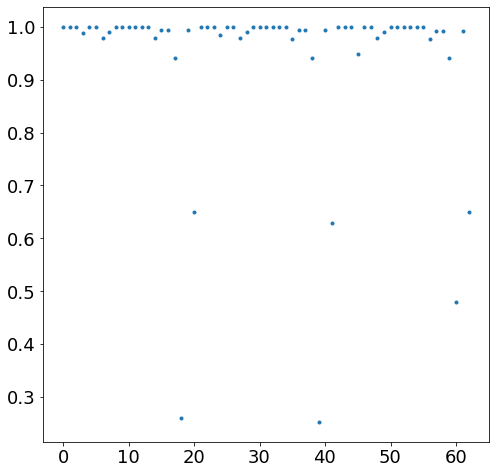

In [36]:
plt.plot(opt_nparr,'.')

## Make a 4-panel plot.
Popt, Psat, NET, NET_wafer

Text(0.5, 1.0, '20210623')

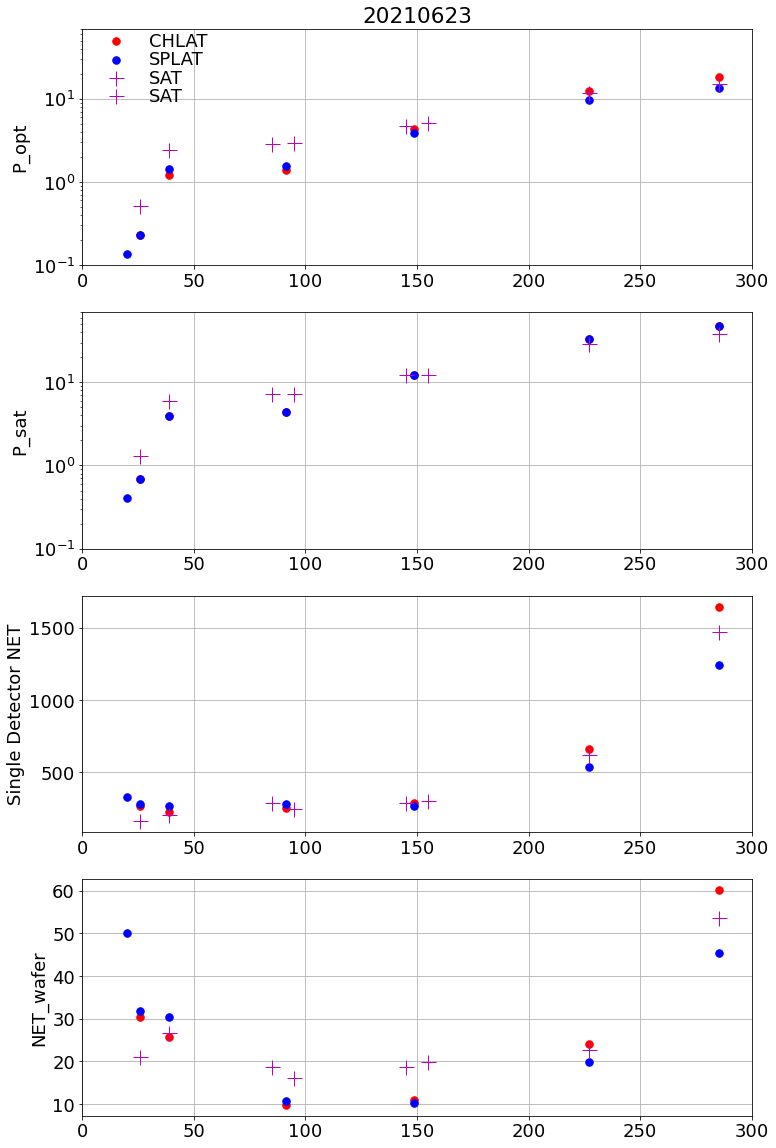

In [5]:
# Plot things vs frequency for each telescope

# Set up a 4-panel plot
plt.clf()
ax1=plt.subplot(4,1,1)
ax1.set_ylabel('P_opt')
ax1.set_xlim(0,300)
ax1.set_ylim(0.1,70)
ax1.grid()
#
ax2=plt.subplot(4,1,2)
ax2.set_ylabel('P_sat')
ax2.set_xlim(0,300)
ax2.set_ylim(0.1,70)
ax2.grid()
#
ax3=plt.subplot(4,1,3)
ax3.set_ylabel('Single Detector NET')
ax3.set_xlim(0,300)
ax3.grid()
#
ax4=plt.subplot(4,1,4)
ax4.set_ylabel('NET_wafer')
ax4.set_xlim(0,300)
ax4.grid()
yfrac = 0.7

for yamlfile in yamlfiles: 
    telescope = yamlfile.split('_')[0]
    if telescope == 'CHLAT':
        pointtype = '.r'
    elif telescope == 'SPLAT':
        pointtype = '.b'
    else:
        pointtype = '+m'
    
    for chname in data[yamlfile].keys():
        if chname != 'defaults':
            nu = data[yamlfile][chname]['bandcenter']
            #
            ax1.semilogy(nu, data[yamlfile][chname]['popt'],pointtype, markersize=15 )
            ax2.semilogy(nu, data[yamlfile][chname]['psat'],pointtype, markersize=15 )
            ax3.plot(nu, data[yamlfile][chname]['net'],pointtype, markersize=15 )
            ax4.plot(nu, data[yamlfile][chname]['netwafer'],pointtype, markersize=15 )
            #
    
    ymin,ymax = ax1.set_ylim()
    xmin,xmax = ax1.set_xlim()
    xval = xmin+0.05*(xmax-xmin)
    yval = ymin+yfrac*(ymax-ymin)
    ax1.semilogy(xval,yval,pointtype,markersize=15)
    ax1.text(xval+0.05*(xmax-xmin),yval,telescope,verticalalignment='center')
    yfrac = yfrac*0.6


ax1.grid()
ax1.grid()
ax1.set_title(version_date)
    

## Make a 4-panel plot.
efficiency, NEP_photon, NEP_phonon, NEP_readout

Text(0.5, 1.0, '20210623')

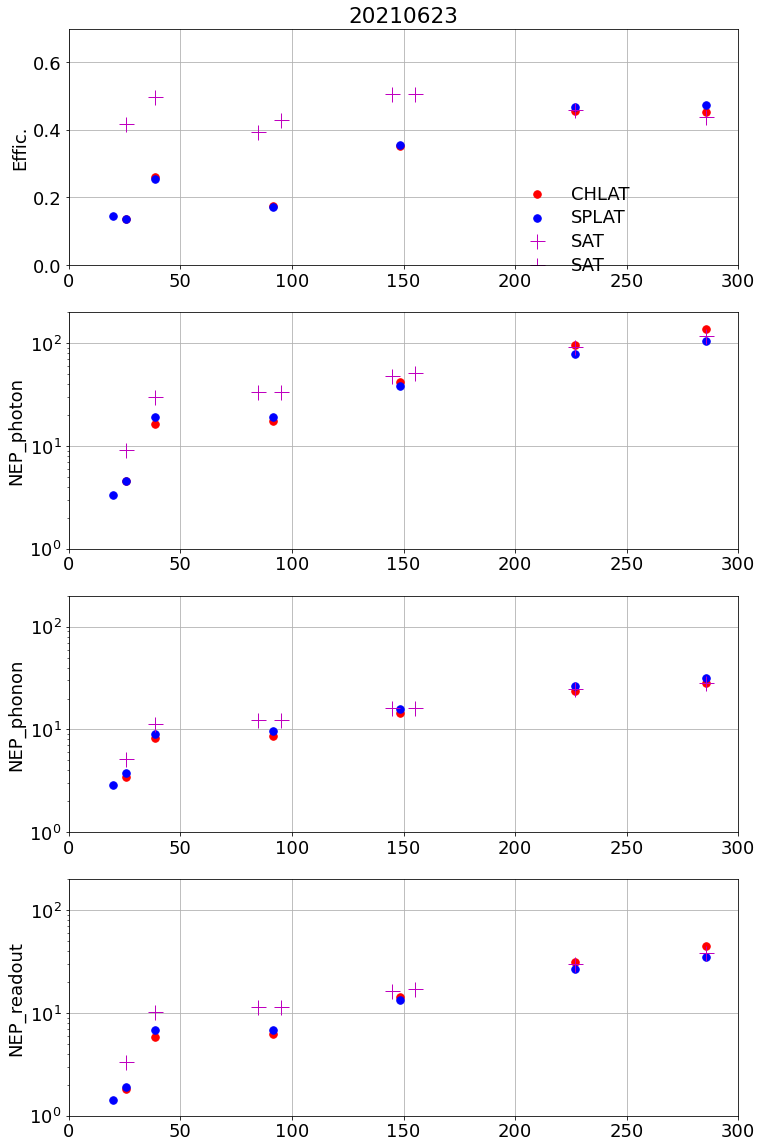

In [6]:
plt.clf()
ax1=plt.subplot(4,1,1)
ax1.set_ylabel('Effic.')
ax1.set_xlim(0,300)
ax1.set_ylim(0,0.7)
ax1.grid()
#
ax2=plt.subplot(4,1,2)
ax2.set_ylabel('NEP_photon')
ax2.set_xlim(0,300)
ax2.set_ylim(1,200)
ax2.grid()
#
ax3=plt.subplot(4,1,3)
ax3.set_ylabel('NEP_phonon')
ax3.set_xlim(0,300)
ax3.set_ylim(1,200)
ax3.grid()
#
ax4=plt.subplot(4,1,4)
ax4.set_ylabel('NEP_readout')
ax4.set_xlim(0,300)
ax4.set_ylim(1,200)
ax4.grid()

#data = {}
yfrac = 0.3

for yamlfile in yamlfiles: 
    telescope = yamlfile.split('_')[0]
    if telescope == 'CHLAT':
        pointtype = '.r'
    elif telescope == 'SPLAT':
        pointtype = '.b'
    else:
        pointtype = '+m'
    
    for chname in data[yamlfile].keys():
        if chname != 'defaults':
            nu = data[yamlfile][chname]['bandcenter']
            #
            ax1.plot(nu, data[yamlfile][chname]['effic'],pointtype, markersize=15 )
            ax2.semilogy(nu, data[yamlfile][chname]['nep_photon'],pointtype, markersize=15 )
            ax3.semilogy(nu, data[yamlfile][chname]['nep_phonon'],pointtype, markersize=15 )
            ax4.semilogy(nu, data[yamlfile][chname]['nep_readout'],pointtype, markersize=15 )

    
    ymin,ymax = ax1.set_ylim()
    xmin,xmax = ax1.set_xlim()
    xval = xmin+0.7*(xmax-xmin)
    yval = ymin+yfrac*(ymax-ymin)
    ax1.plot(xval,yval,pointtype,markersize=15)
    ax1.text(xval+0.05*(xmax-xmin),yval,telescope,verticalalignment='center')
    yfrac = yfrac-0.1


ax1.grid()
ax1.grid()
ax1.set_title(version_date)



In [7]:
# Write to files
data['runtime'] = datetime.today().strftime('%Y/%m/%d %H:%M:%S')
data['input_id'] = version_date
data['variation'] = 'BaseModel'

# Write to toml file
output_file_name = data['variation'] + '.toml'
with open('outputs/' + output_file_name, "w") as toml_file:
    toml.dump(data, toml_file, encoder=toml.TomlNumpyEncoder())

## Notes
Key lists etc.

In [8]:
top.instrument.tables.keys()

dict_keys(['cam_1_HF_1_sims', 'cam_1_HF_2_sims', 'optical'])

In [9]:
top.instrument.tables['cam_1_LF_1_sims'].keys()

KeyError: 'cam_1_LF_1_sims'

In [ ]:
data2 = {}
data2['SAT_pole_20210401'] = {'LF_1': 1.40, 'LF_2': 6.13, 'MF1_1': 7.40, 'MF1_2': 12.25, 'MF2_1': 7.65, 'MF2_2': 13.30, 'UHF_1': 29.88, 'UHF_2': 39.03}
data2['SPLAT_20210401'] = {'ULF': 0.42, 'LF_1': 0.69, 'LF_2': 4.32, 'MF_1': 4.65, 'MF_2': 11.49, 'UHF_1': 29.31, 'UHF_2': 40.02}
data2['CHLAT_20210401'] = {'LF_1': 0.72, 'LF_2': 3.84, 'MF_1': 4.47, 'MF_2': 13.95, 'UHF_1': 41.52, 'UHF_2': 60.78}

# Write to toml file
with open('FixedPsats.toml', "w") as toml_file:
    toml.dump(data2, toml_file, encoder=toml.TomlNumpyEncoder())

In [ ]:
top.instrument.tables.keys()

In [ ]:
data[yamlfile][chname]['Gdyn']